# Multicollinearity

## ¿What is multicollinearity?

Multicollinearity is the occurrence of high intercorrelations among two or more independent variables in a multiple regression model. Multicollinearity can lead to skewed or misleading results when a researcher or analyst attempts to determine how well each independent variable can be used most effectively to predict or understand the dependent variable in a statistical model. For example:

FE: Food Expenditure

$$
FE_i = \beta_0 + \beta_1 Labor Income_i + \beta_2 Non-Labor Income_i + \beta_3 Total Income_i + u_i
$$

$$
Total Income_i = Labor Income_i + Non-Labor Income_i
$$

In this case, Total Income is not relevant since it is a linear combination of labor income and non-labor income and does not provide new information. 

In [35]:
set.seed(10)

#Create a matrix 10x10
A <- matrix(ncol=10, nrow=10)

#9 columnas con distribución normal
for (i in 1:9) {
A[,i]<- rnorm(10,mean=0,sd=1)
}

#seleccionar 3 columnas y hacer combinacion lineal para completar columna 10
A_1 <- A[,1]
A_2 <- A[,4]
A_3 <- A[,7]
A[,10]<- A_1*0.5 + A_2*8.3 + A_3*6

#Calculamos la inversa de la matriz A
A_inversa <- solve(A)
A_inversa

#La matriz a no tiene rango completo, pues la columna 10 es combinación lineal de otras 3 columnas; por lo tanto, la matriz es singular y no puede hallarse su inversa.

ERROR: Error in solve.default(A): sistema es computacionalmente singular: número de condición recíproco = 1.7191e-18


## Analyzing RCT data with Precision Adjustment

## Data

In this lab, we analyze the Pennsylvania re-employment bonus experiment, which was previously studied in "Sequential testing of duration data: the case of the Pennsylvania ‘reemployment bonus’ experiment" (Bilias, 2000), among others. These experiments were conducted in the 1980s by the U.S. Department of Labor to test the incentive effects of alternative compensation schemes for unemployment insurance (UI). In these experiments, UI claimants were randomly assigned either to a control group or one of five treatment groups. Actually, there are six treatment groups in the experiments. Here we focus on treatment group 2. In the control group the current rules of the UI applied. Individuals in the treatment groups were offered a cash bonus if they found a job within some pre-specified period of time (qualification period), provided that the job was retained for a specified duration. The treatments differed in the level of the bonus, the length of the qualification period, and whether the bonus was declining over time in the qualification period.

In [36]:
## loading the data
Penn <- as.data.frame(read.table("../data/penn_jae.dat", header=T ))
n <- dim(Penn)[1]
p_1 <- dim(Penn)[2]
Penn<- subset(Penn, tg==2 | tg==0)
attach(Penn)


The following objects are masked from Penn (pos = 3):

    abdt, agegt54, agelt35, black, dep, durable, female, hispanic,
    husd, inuidur1, inuidur2, lusd, muld, nondurable, othrace, q1, q2,
    q3, q4, q5, q6, recall, tg

The following objects are masked from Penn (pos = 4):

    abdt, agegt54, agelt35, black, dep, durable, female, hispanic,
    husd, inuidur1, inuidur2, lusd, muld, nondurable, othrace, q1, q2,
    q3, q4, q5, q6, recall, tg

The following objects are masked from Penn (pos = 5):

    abdt, agegt54, agelt35, black, dep, durable, female, hispanic,
    husd, inuidur1, inuidur2, lusd, muld, nondurable, othrace, q1, q2,
    q3, q4, q5, q6, recall, tg

The following objects are masked from Penn (pos = 9):

    abdt, agegt54, agelt35, black, dep, durable, female, hispanic,
    husd, inuidur1, inuidur2, lusd, muld, nondurable, othrace, q1, q2,
    q3, q4, q5, q6, recall, tg

The following objects are masked from Penn (pos = 10):

    abdt, agegt54, agelt35, black, dep, dura

In [37]:
T2<- (tg==2)
summary(T2)

   Mode   FALSE    TRUE 
logical    3354    2428 

In [38]:
head(Penn)

,abdt,tg,inuidur1,inuidur2,female,black,hispanic,othrace,dep,q1,...,q5,q6,recall,agelt35,agegt54,durable,nondurable,lusd,husd,muld
1,10824,0,18,18,0,0,0,0,2,0,...,1,0,0,0,0,0,0,0,1,0
2,10635,2,7,3,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,10824,0,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
5,10747,0,27,27,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10,10754,2,20,20,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13,10831,0,27,27,0,0,0,0,1,0,...,1,0,0,0,1,1,0,1,0,0


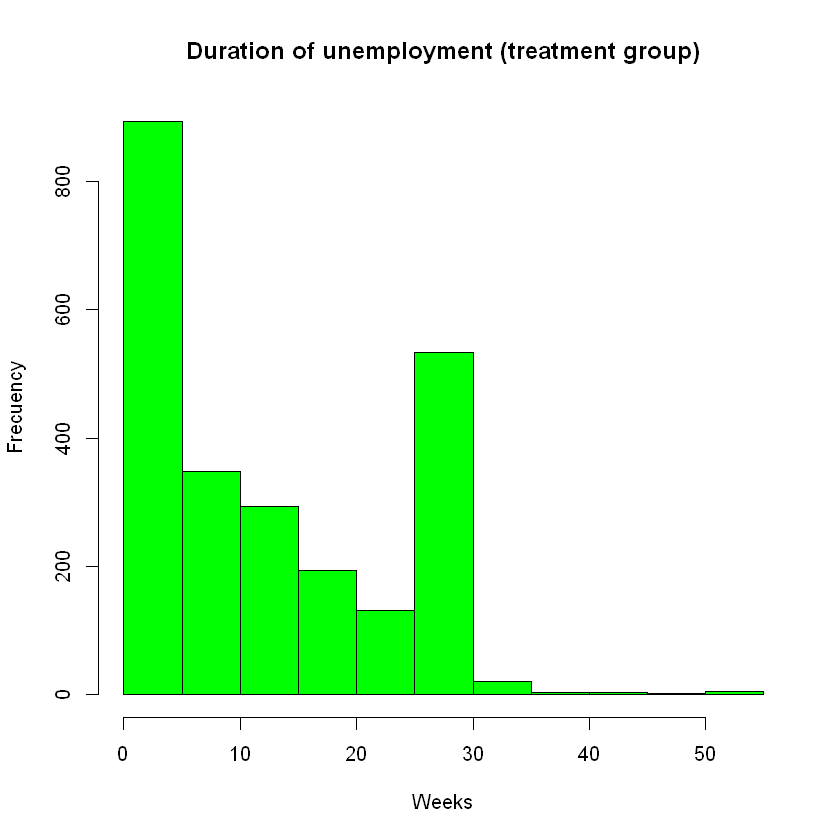

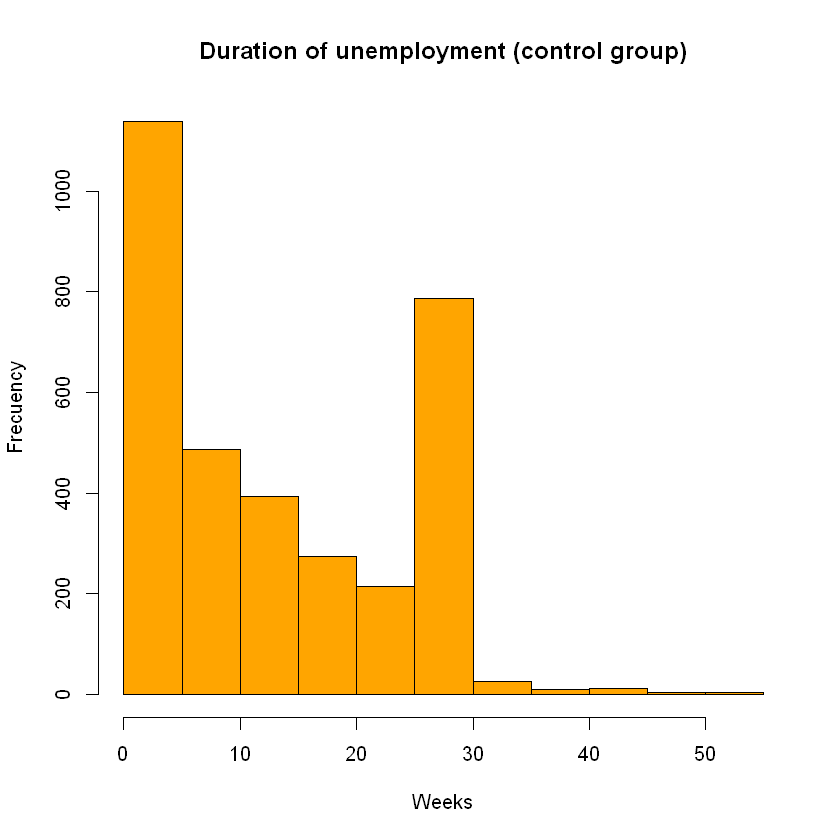

In [39]:
library(tidyverse)

tg_2 <- Penn %>%
filter(tg==2)

tg_0 <- Penn %>%
filter(tg==0)

hist(tg_2$inuidur1,main = "Duration of unemployment (treatment group)",xlab = "Weeks",ylab="Frecuency",col="green")
hist(tg_0$inuidur1,main = "Duration of unemployment (control group)",xlab = "Weeks",ylab="Frecuency",col="orange")

It can be seen that both treatment group 2 and the control group have quite similar distributions.

### Model 
To evaluate the impact of the treatments on unemployment duration, we consider the linear regression model:

$$
Y =  D \beta_1 + W'\beta_2 + \varepsilon, \quad E \varepsilon (D,W')' = 0,
$$

where $Y$ is  the  log of duration of unemployment, $D$ is a treatment  indicators,  and $W$ is a set of controls including age group dummies, gender, race, number of dependents, quarter of the experiment, location within the state, existence of recall expectations, and type of occupation.   Here $\beta_1$ is the ATE, if the RCT assumptions hold rigorously.


We also consider interactive regression model:

$$
Y =  D \alpha_1 + D W' \alpha_2 + W'\beta_2 + \varepsilon, \quad E \varepsilon (D,W', DW')' = 0,
$$

where $W$'s are demeaned (apart from the intercept), so that $\alpha_1$ is the ATE, if the RCT assumptions hold rigorously.

Under RCT, the projection coefficient $\beta_1$ has
the interpretation of the causal effect of the treatment on
the average outcome. We thus refer to $\beta_1$ as the average
treatment effect (ATE). Note that the covariates, here are
independent of the treatment $D$, so we can identify $\beta_1$ by
just linear regression of $Y$ on $D$, without adding covariates.
However we do add covariates in an effort to improve the
precision of our estimates of the average treatment effect.

### Analysis

We consider 

*  classical 2-sample approach, no adjustment (CL)
*  classical linear regression adjustment (CRA)
*  interactive regression adjusment (IRA)
*  interactive regression adjusment (IRA) with Lasso

and carry out robust inference using the *estimatr* R packages. 

# Carry out covariate balance check

This is done using "lm_robust" command which unlike "lm" in the base command automatically does the correct Eicher-Huber-White standard errors, instead othe classical non-robus formula based on the homoscdedasticity command.

In [40]:
m <- lm(T2~(female+black+othrace+factor(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)^2)
library(lmtest)
library(sandwich)
coeftest(m, vcov = vcovHC(m, type="HC1"))


t test of coefficients:

                       Estimate Std. Error t value  Pr(>|t|)    
(Intercept)           0.5171342  0.1568823  3.2963 0.0009856 ***
female                0.0056240  0.1324597  0.0425 0.9661352    
black                -0.0307771  0.0847262 -0.3633 0.7164293    
othrace              -0.4278818  0.3005502 -1.4237 0.1545993    
factor(dep)1          0.1576567  0.1851798  0.8514 0.3945992    
factor(dep)2         -0.1927958  0.1508926 -1.2777 0.2014067    
q2                   -0.1092161  0.1583768 -0.6896 0.4904762    
q3                   -0.1075663  0.1579864 -0.6809 0.4959890    
q4                   -0.0621302  0.1581168 -0.3929 0.6943797    
q5                   -0.0498684  0.1575034 -0.3166 0.7515450    
q6                   -0.2176336  0.1558290 -1.3966 0.1625831    
agelt35              -0.0643464  0.1326376 -0.4851 0.6276032    
agegt54               0.0259251  0.2395371  0.1082 0.9138171    
durable              -0.1256397  0.1763853 -0.7123 0.4763064    

In [41]:
# get same dataframe
X <- as.data.frame( model.matrix(m) )

no_col <- attributes(m$coefficients)$names[is.na(m$coefficients)]

X1  <- X[, -which(names( X ) %in% no_col ) ]

save( X1, file = "../data/m_reg3.RData")

We see that that even though this is a randomized experiment, balance conditions are failed.

# Model Specification

In [42]:
# model specifications


# no adjustment (2-sample approach)
formula_cl <- log(inuidur1)~T2

# adding controls
formula_cra <- log(inuidur1)~T2+ (female+black+othrace+factor(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)^2
# Omitted dummies: q1, nondurable, muld


ols.cl_reg <- lm(formula_cl)
ols.cra_reg <- lm(formula_cra)


ols.cl = coeftest(ols.cl_reg, vcov = vcovHC(ols.cl_reg, type="HC1"))
ols.cra = coeftest(ols.cra_reg, vcov = vcovHC(ols.cra_reg, type="HC1"))

print(ols.cl)
print(ols.cra)


t test of coefficients:

             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.056830   0.020954 98.1580  < 2e-16 ***
T2TRUE      -0.078825   0.032509 -2.4247  0.01535 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


t test of coefficients:

                       Estimate Std. Error t value  Pr(>|t|)    
(Intercept)           2.4471832  0.3580899  6.8340 9.123e-12 ***
T2TRUE               -0.0712066  0.0320440 -2.2222 0.0263124 *  
female               -0.9428048  0.2827961 -3.3339 0.0008620 ***
black                -0.6654258  0.2430567 -2.7377 0.0062056 ** 
othrace              -1.5494550  0.7312071 -2.1190 0.0341306 *  
factor(dep)1          0.2798498  0.3783316  0.7397 0.4595160    
factor(dep)2          0.1678164  0.3678718  0.4562 0.6482768    
q2                    0.0271228  0.3606226  0.0752 0.9400495    
q3                   -0.3542370  0.3601780 -0.9835 0.3254005    
q4                   -0.3380244  0.3606994 -0.9371 0.3487284    
q5 

In [50]:
# get same dataframe for ols.cl
X <- as.data.frame( model.matrix(ols.cl_reg) )

no_col <- attributes(ols.cl_reg$coefficients)$names[is.na(ols.cl_reg$coefficients)]

X1  <- X[, -which(names( X ) %in% no_col ) ]

save( X1, file = "../data/ols_cl_reg3.RData")

# get same dataframe for ols.cl
X <- as.data.frame( model.matrix(ols.cra_reg) )

no_col <- attributes(ols.cra_reg$coefficients)$names[is.na(ols.cra_reg$coefficients)]

X1  <- X[, -which(names( X ) %in% no_col ) ]

save( X1, file = "../data/ols_cra_reg3.RData")

The interactive specificaiton corresponds to the approach introduced in Lin (2013).

In [43]:

#interactive regression model;

X = model.matrix (~ (female+black+othrace+factor(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)^2)[,-1]
dim(X)
demean<- function(x){ x - mean(x)}
X = apply(X, 2, demean)

ols.ira_reg = lm(log(inuidur1) ~ T2*X) 
ols.ira= coeftest(ols.ira_reg, vcov = vcovHC(ols.ira_reg, type="HC1"))
print(ols.ira)

[1] 5782  119


t test of coefficients:

                               Estimate Std. Error t value  Pr(>|t|)    
(Intercept)                   2.0556976  0.0207138 99.2430 < 2.2e-16 ***
T2TRUE                       -0.0699044  0.0320764 -2.1793 0.0293503 *  
Xfemale                      -0.6662823  0.4080234 -1.6330 0.1025357    
Xblack                       -0.8634862  0.2969435 -2.9079 0.0036528 ** 
Xothrace                     -3.8176881  0.9366193 -4.0760 4.645e-05 ***
Xfactor(dep)1                 0.0359264  0.6476816  0.0555 0.9557666    
Xfactor(dep)2                 0.2117556  0.4512231  0.4693 0.6388790    
Xq2                          -0.2546436  0.4553391 -0.5592 0.5760207    
Xq3                          -0.6212326  0.4549639 -1.3655 0.1721653    
Xq4                          -0.4799269  0.4561206 -1.0522 0.2927566    
Xq5                          -0.3718675  0.4538882 -0.8193 0.4126542    
Xq6                          -0.6770474  0.4521499 -1.4974 0.1343469    
Xagelt35                 

In [44]:
# get same dataframe for ols.ira
S <- as.data.frame( model.matrix(ols.ira_reg) )

no_col <- attributes(ols.ira_reg$coefficients)$names[is.na(ols.ira_reg$coefficients)]

S1  <- S[, -which(names( S ) %in% no_col ) ]

save( S1, file = "../data/ols_ira_reg3.RData")


In [45]:
dim(ols.ira)

[1] 203   4

Next we try out partialling out with lasso

In [46]:
library(hdm)

T2 = demean(T2)

DX = model.matrix(~T2*X)[,-1]

rlasso.ira = summary(rlassoEffects(DX, log(inuidur1), index = 1))


print(rlasso.ira)

Warning message:
"package 'hdm' was built under R version 3.6.3"

[1] "Estimates and significance testing of the effect of target variables"
   Estimate. Std. Error t value Pr(>|t|)  
T2  -0.07457    0.03209  -2.324   0.0201 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




In [47]:
# getting data
S = as.data.frame(DX)
save( S, file = "../data/rlasso_ira_reg3.RData")

### Results

In [48]:
library(xtable)
table<- matrix(0, 2, 4)
table[1,1]<-  ols.cl[2,1]
table[1,2]<-  ols.cra[2,1]
table[1,3]<-  ols.ira[2,1]
table[1,4]<-  rlasso.ira[[1]][1]

table[2,1]<-  ols.cl[2,2]
table[2,2]<-  ols.cra[2,2]
table[2,3]<-  ols.ira[2,2]
table[2,4]<-  rlasso.ira[[1]][2]


colnames(table)<- c("CL","CRA","IRA", "IRA w Lasso")
rownames(table)<- c("estimate", "standard error")
tab<- xtable(table, digits=5)
tab

print(tab, type="latex", digits=5)

,CL,CRA,IRA,IRA w Lasso
estimate,-0.07882533,-0.07120664,-0.06990440,-0.07457328
standard error,0.03250889,0.03204403,0.03207638,0.03208892


% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Fri Sep 24 16:04:13 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrrrr}
  \hline
 & CL & CRA & IRA & IRA w Lasso \\ 
  \hline
estimate & -0.07883 & -0.07121 & -0.06990 & -0.07457 \\ 
  standard error & 0.03251 & 0.03204 & 0.03208 & 0.03209 \\ 
   \hline
\end{tabular}
\end{table}


Treatment group 2 experiences an average decrease of about $7.4\%$ in the length of unemployment spell.


Observe that regression estimators delivers estimates that are slighly more efficient (lower standard errors) than the simple 2 mean estimator, but essentially all methods have very similar standard errors. From IRA results we also see that there is not any statistically detectable heterogeneity.  We also see the regression estimators offer slightly lower estimates -- these difference occur perhaps to due minor imbalance in the treatment allocation, which the regression estimators try to correct.


,T2*female,T2*black,T2*agelt35,T2*factor(dep)1
Estimación,-0.6597505,0.452557,1.12332,0.7636025


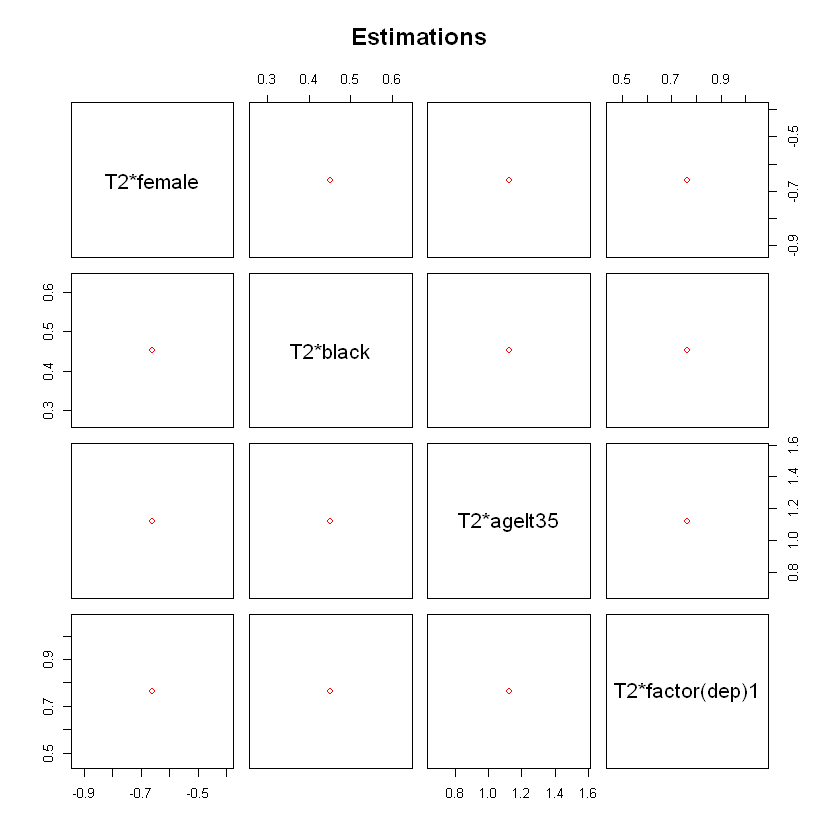

In [49]:
library(ggplot2)

a <- ols.ira['T2TRUE:Xfemale','Estimate']
b <- ols.ira['T2TRUE:Xblack','Estimate']
c <- ols.ira['T2TRUE:Xagelt35','Estimate']
d <- ols.ira['T2TRUE:Xfactor(dep)1','Estimate']
coef <- data.frame(a,b,c,d)
rownames(coef) <- "Estimación"
colnames(coef) <- c("T2*female","T2*black","T2*agelt35","T2*factor(dep)1")
coef
plot(coef, main="Estimations",col = "red")

**T2*female** : Women on treatment 2 take $65.97\%$ fewer weeks than men on treatment 2.

**T2*black**: People with black skin under treatment 2 take $45.25\%$ weeks longer than those without black skin to find work.

**T2*agelt35**: People under 35 receiving treatment 2 take $112\%$ weeks longer to get a job than those over 35 receiving treatment.

**T2*factor(dep)1**: Individuals who have a dependent and are on treatment 2 take $76\%$ weeks longer than those who do not have a dependent and are on treatment 2.